# Imports + Misc Fns

In [1360]:
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
import requests

In [1361]:
FF = lambda x: np.array([x])

In [1362]:
def plotContour(ws, bs, X, y, loss, levels=np.arange(0, 100, 10), do3d = False):
    """
    Plots a contour of the loss for some ws and bs, given some test data.  

    ---
    ws: the list of ws to plot the loss of  
    bs: the list of bs to plot the loss of  
    X: the list of input values to use for calculating the loss
    y: the list of output values to use for calculating the loss  
    loss: the loss function to use. Should take in the ws and bs.
    levels: the list of levels to display (defaults to `0, 10, 20, ..., 100`)  
    do3d: whether to plot 3d or not. As in, if this is false (by default), will display a normal contour plot. Otherwise, the function will display a 3d surface plot of the loss.  
    """
    ww, bb = np.meshgrid(ws, bs)
    res = loss(ww, bb, X, y)
    if not do3d:
        plt.contour(ww, bb, res, levels, cmap=cm.coolwarm)
    else:
        # not technically a contour plot, but it works
        ax = plt.figure().add_subplot(projection='3d')
        ax.plot_surface(ww, bb, res, cmap=cm.coolwarm)

# Model Class

In [1363]:
class Optimizer():
    def __init__(self, optimizer=None) -> None:
        self.optim = optimizer
        pass

    def __call__(self, w, b, X, y, lr) -> tuple[int, int]:
        pass

In [1364]:
class LinearRegression:
    def __init__(self, w, b, loss, grad=None, optimizer=None):
        self.w = w
        self.b = b
        self.main_loss = loss
        self.main_grad = grad
        self.optimizer = optimizer

    def predict(self, T):
        return self.w * T + self.b

    def plot(self):
        # plot the line drawn by the model
        pass

    def step(self, X, y, lr):
        """
        Allows for different w and b params, but defalt to same
        """
        dw, db = self.main_grad(self.w, self.b, X, y)
        self.w -= lr * dw
        self.b -= lr * db
        return self.w, self.b

    def train(self, X, y, lr, steps, ret_pts = False):
        ws, bs = np.zeros((steps+1)), np.zeros((steps+1))
        ws[0] = self.w
        bs[0] = self.b
        for i in range(steps):
            if self.optimizer is not None:
                self.w, self.b = self.optimizer(self.w, self.b, X, y, lr)
            else:
                self.w, self.b = self.step(X, y, lr)
            ws[i+1] = self.w
            bs[i+1] = self.b
        if ret_pts:
            return ws, bs
        return self.w, self.b
    
    '''
    static fns below
    '''

    def l1_grad(w, b, X, y):
        """
        ```
        loss = mean( |w*X + b - y| )  
        dw   = mean( sign(w*X + b - y)*X )
        db   = mean( sign(w*X + b - y)   )
        ```
        """
        pur = np.sign(w*X+b-y)
        dw = np.mean(pur*X)
        db = np.mean(pur)
        return dw, db

    def l2_grad(w, b, X, y):
        """
        ```
        loss = mean( (w*X + b - y)^2 )  
        dw   = mean( 2*(w*X+b-y)*X )
        db   = mean( 2*(w*X+b-y)   ) 
        ``` 
        """
        ls = w*X+b-y
        dw = np.mean(2*ls*X)
        dh = np.mean(2*ls)
        return dw, dh

    def toy_grad(w, b, X, y):
        # this is toy, so ignore X and y params
        dw = 20 * (w - 2)
        db = 2 * (b - 1)
        return dw, db
    
    def logcosh_grad(w, b, X, y):
        """
        ```
        loss = mean( ln(cosh( w*X + b - y ) ) )
        dw   = mean( X * sinh( w*X + b - y ) / cosh( w*X + b - y ) )
        db   = mean( sinh( w*X + b - y ) / cosh( w*X + b - y ) )
        ``` 
        """
        ls = LinearRegression.quickloss(w, b, X, y, do_abs=0, pure=1)
        dw = np.mean(X*np.sinh(ls)/np.cosh(ls))
        db = np.mean(np.sinh(ls)/np.cosh(ls))
        return dw, db

    def quickloss(w, b, X, y, pw=1, pure=0, do_abs=1):
        '''
        Quick loss function for testing multiple ws and bs over some X and y data

        ---
        w: the _list_ of ws to test on  
        b: the _list_ of bs to test on  
        X: the _list_ of input values to use for calculating the loss
        y: the _list_ of output values to use for calculating the loss 
        pw: the power for the loss (`1` means L1 loss, `2` means L2, etc)  
        pure: whether to return the whole array (True) or just the mean (False) 
        '''
        if not (isinstance(w, np.ndarray)): w = FF(w)
        if not (isinstance(b, np.ndarray)): b = FF(b)
        vl = (w.flatten()[None, :]*X[:, None] + b.flatten()[None, :]) - y[:, None]
        if (do_abs):
            vl = np.abs(vl)
        vl = vl**pw
        if (pure):
            return vl
        return np.mean(vl, axis=0).reshape(w.shape)

    def l2_loss(*args, **kwargs):
        kwargs.pop("pw", None)
        return LinearRegression.quickloss(*args, **kwargs, pw=2)
    
    def l1_loss(*args, **kwargs):
        kwargs.pop("pw", None)
        return LinearRegression.quickloss(*args, **kwargs, pw=1)

    def toy_loss(w, b, *args, **kwargs):
        return 10 * (w - 2) ** 2 + (b - 1) ** 2 

    def logcosh_loss(w, b, X, y, pure=0, do_abs=1):
        if not (isinstance(w, np.ndarray)): w = FF(w)
        if not (isinstance(b, np.ndarray)): b = FF(b)
        vl = (w.flatten()[None, :]*X[:, None] + b.flatten()[None, :]) - y[:, None]
        if (do_abs):
            vl = np.abs(vl)
        vl = np.log(np.cosh(vl))
        if (pure):
            return vl
        return np.mean(vl, axis=0).reshape(w.shape)

# Part 1: Check Gradient Descent Code on Toy Example

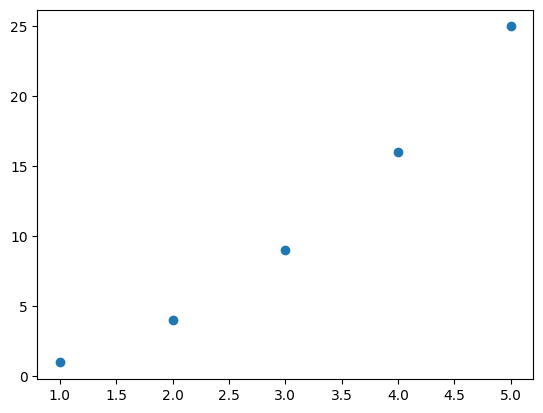

In [1365]:
X = np.arange(1,6)
y = X ** 2
plt.scatter(X, y)

## Check L2 Loss function

In [1366]:
print(LinearRegression.l2_loss(0, 0, X, y))

[195.8]


### Gradient check
Starting with parameters $w = 0, b= 0$, what is the gradient? Show your numerical check function and analytic expression agree.

In [1367]:
def stupid_grad(w, b, X, y, loss, h=0.01):
    dw = (loss(w+h, b, X, y) - loss(w-h, b, X, y)) / (2*h)
    db = (loss(w, b+h, X, y) - loss(w, b-h, X, y)) / (2*h)
    return dw[0], db[0]

In [1368]:
print(LinearRegression.l2_grad(0, 0, X, y), stupid_grad(0, 0, X, y, LinearRegression.l2_loss))

(-90.0, -22.0) (-90.00000000000057, -22.000000000001307)


### Explicit Solution
Find the exact expression for the best fit line, which we derived in class.

Show your code is converging to that solution.

Make a contour plot of the loss.

Huge thanks to Jasper for pointing me in the right direction for this

we want to minimize $f(w, b) = \frac{1}{n}\sum\{wx+b-y\}$  
$\implies \frac{df}{dw} = \frac{1}{n}\sum\{2(wx+b-y)x\} = 0$  
    $\text{ }\implies\sum\{(wx+b-y)x\} = 0$ 
    $\text{ }\implies\sum\{wx^2+bx-yx\} = 0$  
    $\text{ }\implies\sum\{bx\} = \sum\{yx-wx^2\}$  
    $\text{ }\implies b\sum\{x\} = \sum\{yx-wx^2\}$  
    $\text{ }\implies b = \frac{\sum\{yx-wx^2\}}{\sum\{x\}}$  
$\implies \frac{df}{db} = \frac{1}{n}\sum\{2(wx+b-y)\} = 0$      
    $\text{ }\implies\sum\{wx+b-y\} = 0$     
    $\text{ }\implies\sum\{b\} = \sum\{y-wx\}$     
    $\text{ }\implies b = \frac{\sum\{y-wx\}}{n}$    

$\frac{\sum\{yx-wx^2\}}{\sum\{x\}} = \frac{\sum\{y-wx\}}{n}$   
    $\text{ }\implies n\sum\{yx-wx^2\} = \sum\{x\}\sum\{y-wx\}$   
    $\text{ }\implies n\sum\{yx\} - n\sum\{wx^2\} = \sum\{x\}\sum\{y\} - \sum\{x\}\sum\{wx\}$   
    $\text{ }\implies n\sum\{yx\} - \sum\{x\}\sum\{y\} =  n\sum\{wx^2\} - \sum\{x\}\sum\{wx\}$   
    $\text{ }\implies n\sum\{yx\} - \sum\{x\}\sum\{y\} =  wn\sum\{x^2\} -  w\sum\{x\}\sum\{x\}$   
    $\text{ }\implies n\sum\{yx\} - \sum\{x\}\sum\{y\} =  w (n\sum\{x^2\} - \sum\{x\}\sum\{x\})$   
    $\text{ }\implies w = \frac{n\sum\{yx\} - \sum\{x\}\sum\{y\}}{n\sum\{x^2\} - \sum\{x\}\sum\{x\}} $


5.924639430323797 -6.727924431689635


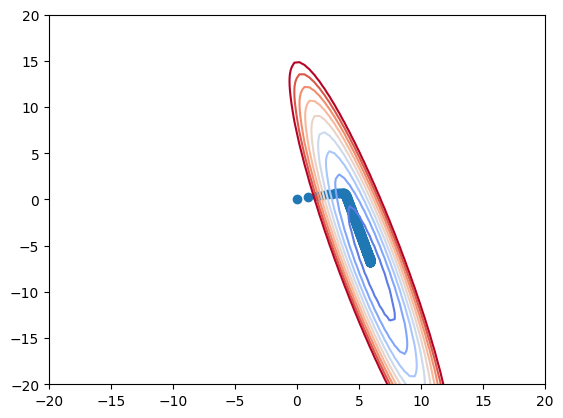

In [1369]:
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad)
ww_l2, bb_l2 = model.train(X, y, 0.01, 1000, 1)
w_l2, b_l2 = ww_l2[-1], bb_l2[-1]
print(w_l2, b_l2)
plotContour(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100), X, y, LinearRegression.l2_loss)
plt.scatter(ww_l2, bb_l2)

In [1370]:
# by math:
w = (len(X) * np.sum(X*y) - np.sum(X)*np.sum(y))/(len(X)*np.sum(X*X) - np.sum(X)**2)
b = np.mean(y - w*X)
print(w, b)

6.0 -7.0


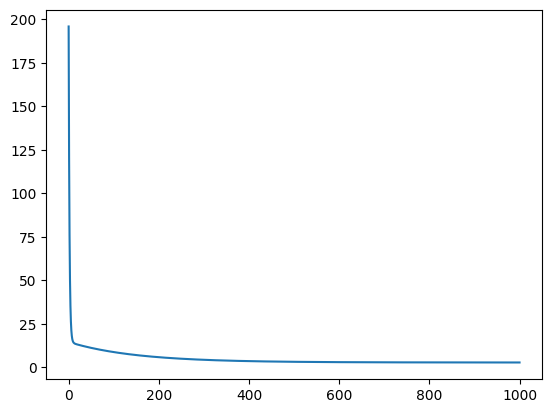

In [1371]:
plt.plot(np.arange(len(ww_l2)), LinearRegression.l2_loss(ww_l2, bb_l2, X, y))

## Check L1 Loss Function

In [1372]:
print(LinearRegression.l1_loss(0, 0, X, y))

[11.]


### Gradient check
Starting with parameters $w = 0, b= 0$, what is the gradient? Show your numerical check function and analytic expression agree.

In [1373]:
print(LinearRegression.l1_grad(0, 0, X, y), stupid_grad(0, 0, X, y, LinearRegression.l1_loss))

(-3.0, -1.0) (-2.999999999999936, -0.9999999999999787)


### Explicit Solution
Make a contour plot of the loss.

Show your code is converging to the minimum.


<!-- $\renewcommand{\t}{\text}$
$\renewcommand{\sgn}{\t{sign}}$
want to minimize $f(w, b) = \frac{1}{n}\sum\{|wx+b-y|\}$

$\implies \frac{df}{dw} = \frac{1}{n}\sum\{\sign(w*x + b - y)*x\} = 0$   
    $\t{ }\implies \frac{1}{n}\sum\{\frac{w*x + b - y}{|w*x + b - y|}*x\} = 0$  
    $\t{ }\implies \frac{1}{n}\sum\{\frac{w*x^2 + bx - yx}{|w*x + b - y|}\} = 0$   -->


5.960000000000076 -7.799999999999915


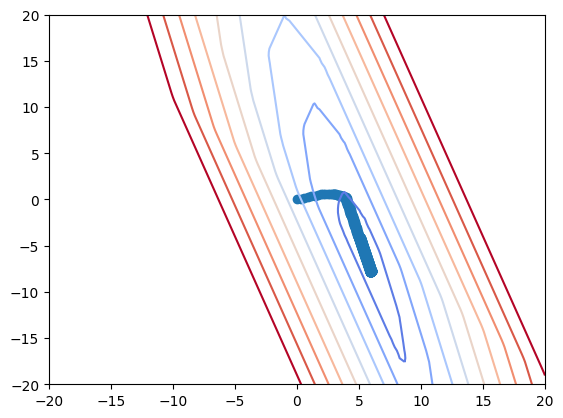

In [1374]:
model = LinearRegression(0, 0, LinearRegression.l1_loss, LinearRegression.l1_grad)
ww_l1, bb_l1 = model.train(X, y, 0.1, 1000, 1)
w_l1, b_l1 = ww_l1[-1], bb_l1[-1]
print(w_l1, b_l1)
plotContour(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100), X, y, LinearRegression.l1_loss,levels=np.linspace(0, 30, 10))
plt.scatter(ww_l1, bb_l1)

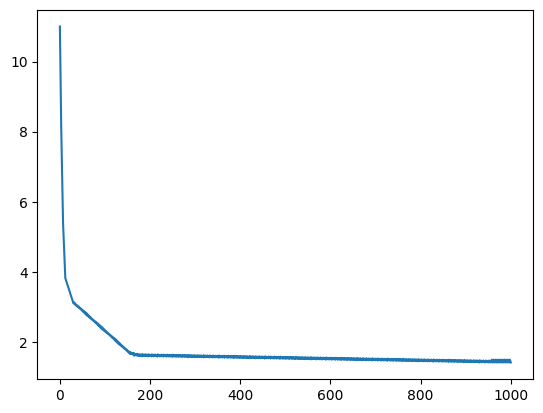

In [1375]:
plt.plot(np.arange(len(ww_l1)), LinearRegression.l1_loss(ww_l1, bb_l1, X, y))

### Bonus: What is the exact expression for this minimum line. Explain why it is the minimum.

## New Loss Function: log(cosh)
L1 Loss: $\frac{1}{n}\sum_{i=1}^n |{\hat{y}}_i-y|$

L2 Loss: $\frac{1}{n}\sum_{i=1}^n ({\hat{y}}_i-y)^2$

LogCosh: $\frac{1}{n}\sum_{i=1}^n \ln(\cosh(\hat{y}_i-y))$

In [1376]:
print(LinearRegression.logcosh_loss(0, 0, X, y))


[10.33230551]


### Gradient check
Starting with parameters $w = 0, b= 0$, what is the gradient? Show your numerical check function and analytic expression agree.

In [1377]:
print(LinearRegression.logcosh_grad(0, 0, X, y), stupid_grad(0, 0, X, y, LinearRegression.logcosh_loss, 0.01))

(-2.8565540551409083, -0.9521846850469696) (-2.9520483290024657, -0.9521825437904141)


### Explicit Solution
Make a contour plot of the loss.

Show your code is converging to the minimum.

2.7088312023259373 0.9029437341086453
[3.3980059]
(-1.3500311979441904e-15, -4.2188474935755947e-16)


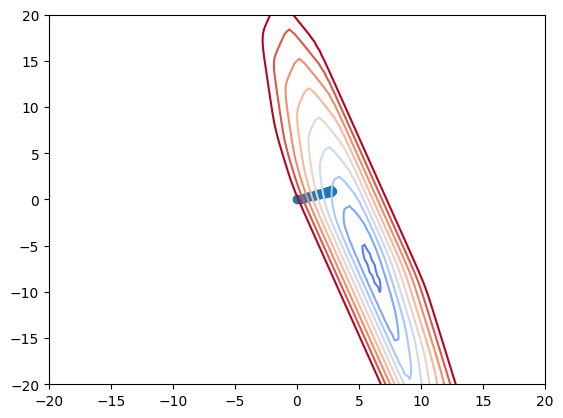

In [1378]:
# not working yet, :((
model = LinearRegression(0, 0, LinearRegression.logcosh_loss, LinearRegression.logcosh_grad)
ww_cosh, bb_cosh = model.train(X, y, 0.1, 1000, 1)
w_cosh, b_cosh = ww_cosh[-1], bb_cosh[-1]
print(w_cosh, b_cosh)
print(LinearRegression.logcosh_loss(w_cosh, b_cosh, X, y))
print(LinearRegression.logcosh_grad(w_cosh, b_cosh, X, y))
plotContour(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100), X, y, LinearRegression.logcosh_loss, levels=np.linspace(0, 10, 10))
plt.scatter(ww_cosh, bb_cosh)

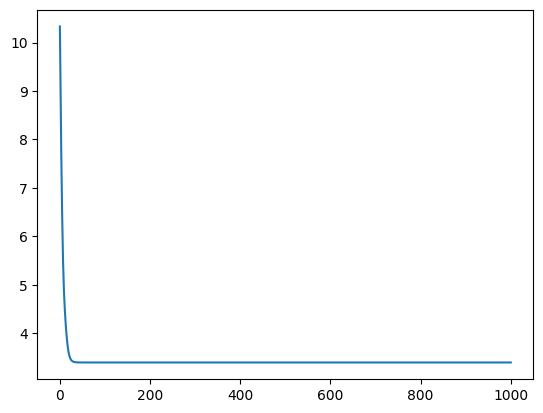

In [1379]:
plt.plot(np.arange(len(ww_cosh)), LinearRegression.logcosh_loss(ww_cosh, bb_cosh, X, y))

## Comparison of Loss Functions
Compare the line of best fit for L2, L1, LogCosh. How do they relate?

Show mathematically how LogCosh relates to L2 and L1.

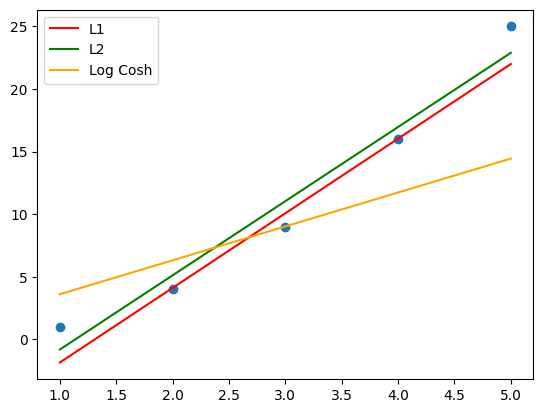

In [1380]:
plt.scatter(X, y)
plt.plot(X, w_l1*X + b_l1, c="red", label="L1")
plt.plot(X, w_l2*X + b_l2, c="green", label="L2")
plt.plot(X, w_cosh*X + b_cosh, c="orange", label="Log Cosh")
plt.legend(loc = "upper left")

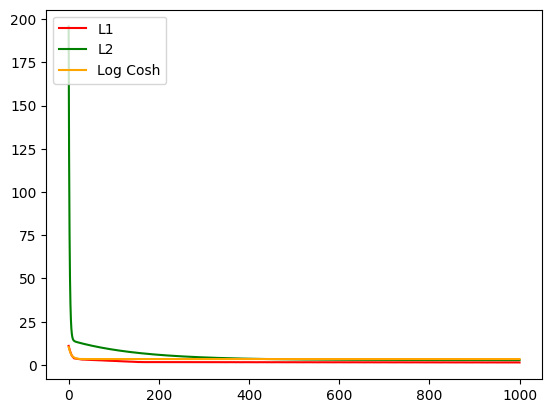

In [1381]:
plt.plot(np.arange(len(ww_l1)), LinearRegression.l1_loss(ww_l1, bb_l1, X, y), c='red', label="L1")
plt.plot(np.arange(len(ww_l2)), LinearRegression.l2_loss(ww_l2, bb_l2, X, y), c='green', label="L2")
plt.plot(np.arange(len(ww_cosh)), LinearRegression.logcosh_loss(ww_cosh, bb_cosh, X, y), c='orange', label="Log Cosh")
plt.legend(loc = "upper left")


## Why Learning Rate Matters

These are not the same graphs as before as different test data now, but same idea

### Exhibit A: Too small a learning rate (0.0001)

3.4928819187703106 0.6795071570770189


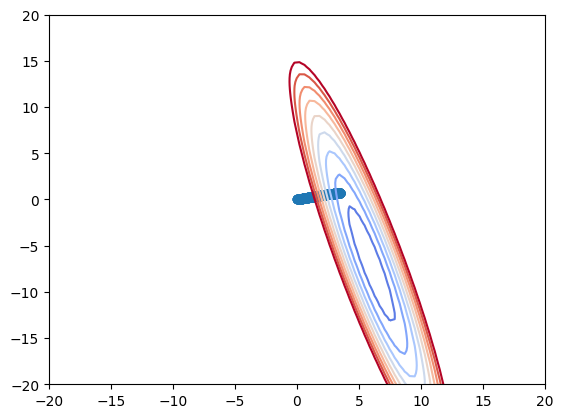

In [1382]:
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad)
ww_l2, bb_l2 = model.train(X, y, 0.0001, 1000, 1)
w_l2, b_l2 = ww_l2[-1], bb_l2[-1]
print(w_l2, b_l2)
plotContour(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100), X, y, LinearRegression.l2_loss)
plt.scatter(ww_l2, bb_l2)

### Exhibit B: A good learning rate (0.01)

5.924639430323797 -6.727924431689635


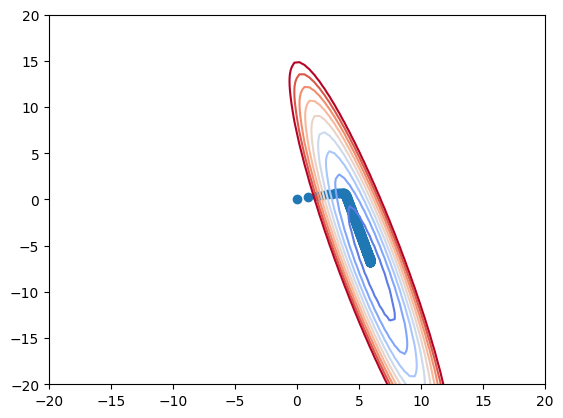

In [1383]:
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad)
ww_l2, bb_l2 = model.train(X, y, 0.01, 1000, 1)
w_l2, b_l2 = ww_l2[-1], bb_l2[-1]
print(w_l2, b_l2)
plotContour(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100), X, y, LinearRegression.l2_loss)
plt.scatter(ww_l2, bb_l2)

### Exhibit C: A bad learning rate (0.1)

-1.2239530884662897e+136 -3.3901537935427374e+135


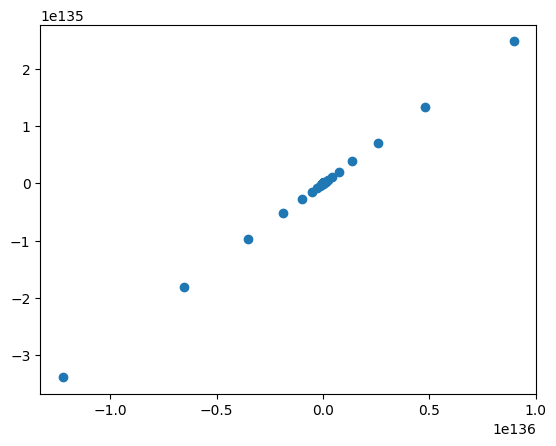

In [1384]:
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad)
ww_l2, bb_l2 = model.train(X, y, 0.1, 1000, 1)
w_l2, b_l2 = ww_l2[-1], bb_l2[-1]
print(w_l2, b_l2)
plotContour(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100), X, y, LinearRegression.l2_loss)
plt.scatter(ww_l2, bb_l2)

# Part 2: Large and More Difficult Example

## Introduce your example

Show what your dataset is. Find the exact expression for the best fit line, show a contour plot of the loss function. It should be a pretty long and skinny ellipse.

We will start all optimization schemes at $w, b = 0, 0$

In [1385]:
csv = requests.get("http://www.aayanarish.com/ml_datasets/AAPL.csv").text

data = csv.split("\n")
data = [data[i].split(",") for i in range(len(data)) if i > 1 and i < len(data)-1]
dates, price, *_ = list(zip(*data))
print(len(dates), len(price))
dates = np.array(dates)
price = np.array(price, dtype=np.float32)
print("Samples: ")
print(" Dates\t\tPrice")
print(*zip(dates[:10], price[:10]), sep="\n")


9908 9908
Samples: 
 Dates		Price
('1980-12-15', 0.4888393)
('1980-12-16', 0.453125)
('1980-12-17', 0.46205357)
('1980-12-18', 0.47544643)
('1980-12-19', 0.50446427)
('1980-12-22', 0.52901787)
('1980-12-23', 0.55133927)
('1980-12-24', 0.58035713)
('1980-12-26', 0.6339286)
('1980-12-29', 0.64285713)


Text(0, 0.5, 'Stock')

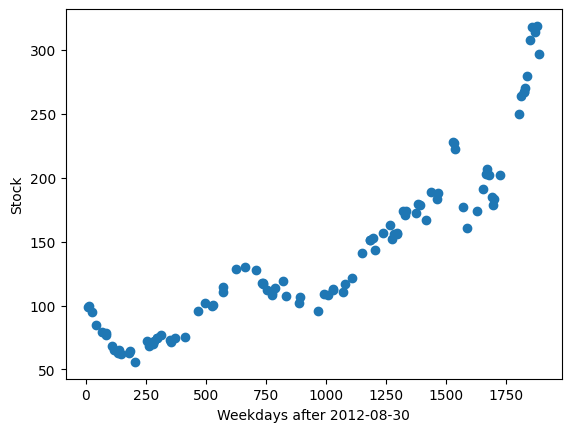

In [1386]:
strt = 8000
inds = np.arange(strt, len(dates))
rng = np.random.default_rng(16)
nds = rng.choice(inds, (100))
X, y = nds-strt, price[nds]
plt.scatter(X, y)
plt.xlabel(f"Weekdays after {dates[strt]}")
plt.ylabel("Stock")

In [1387]:
# True best w and b, by l2
ans_w = (len(X) * np.sum(X*y) - np.sum(X)*np.sum(y))/(len(X)*np.sum(X*X) - np.sum(X)**2)
ans_b = np.mean(y - ans_w*X)
print(ans_w, ans_b, LinearRegression.l2_loss(ans_w, ans_b, X, y))

0.10203680758058756 44.14221072442803 [817.06379624]


## Explore Optimization Methods
For each method, show a plot of it moving in parameter space, as well as a plot of loss vs number of iterations. You should vary the associated hyperparameter (show a few loss curves, one where hyperparameter is too big and also too small)

##### Consts needed for later

In [1388]:
# consts needed for later things
lvls = [0]*3
lvls[1] = np.arange(0, 150, 15)
lvls[2] = np.arange(500, 100000, 10000)
w_contour = np.linspace(-0.25, 0.25, 400)
b_contour = np.linspace(-120, 120, 400)

### Random Local Search
Learning rate parameter

#### Class + plot fn

In [1389]:
class RandomLocalSearch(Optimizer):
    def __init__(self, loss, optimizer=None) -> None:
        self.loss = loss
        super().__init__(optimizer)
    
    def __call__(self, w, b, X, y, lr):
        w2 = w + np.random.normal(0, 1)*lr
        b2 = b + np.random.normal(0, 1)*lr
        if self.loss(FF(w2), FF(b2), X, y) < self.loss(FF(w), FF(b), X, y):
            return w2, b2
        return w, b

In [1390]:
def do_rls_plot(w, b, lr, contourw, contourb, X, y, loss, lvl, steps=1000):
    '''
    plots rls
    found that making this sort of tester code function couldn't work well 
    with different models that have lots of different hyperparams and each 
    are only used 1-2 times, so I scrapped this function technique after RLS
    '''
    model = LinearRegression(w, b, loss, optimizer=RandomLocalSearch(loss))
    ww, bb = model.train(X, y, lr, steps, ret_pts=1)
    plotContour(contourw, contourb, X, y, loss, levels=lvl)
    plt.scatter(ww, bb)
    return ww, bb

#### Good Learning Rate

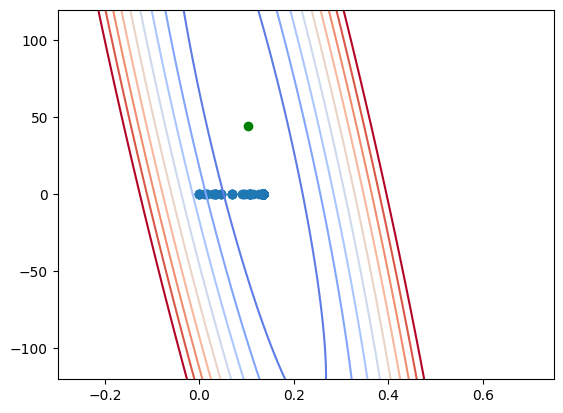

In [1391]:
ww_rls, bb_rls = do_rls_plot(0, 0, 0.01, np.linspace(-0.3, 0.75, 400), b_contour, X, y, LinearRegression.l2_loss, lvls[2], 500)
plt.scatter(ans_w, ans_b, c="green")

#### Bad Learning Rate

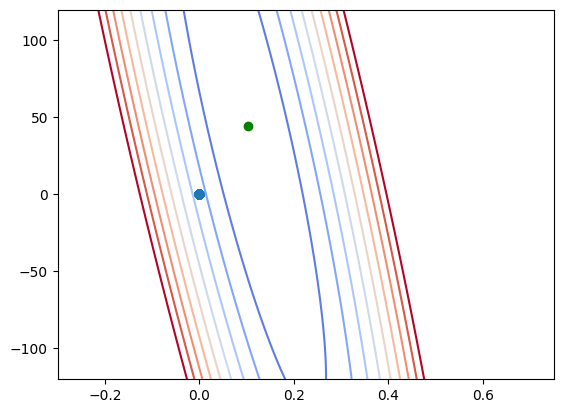

In [1392]:
ww_rls_bad, bb_rls_bad = do_rls_plot(0, 0, 50, np.linspace(-0.3, 0.75, 400), b_contour, X, y, LinearRegression.l2_loss, lvls[2], 500)
plt.scatter(ans_w, ans_b, c="green")

#### Loss Comparison

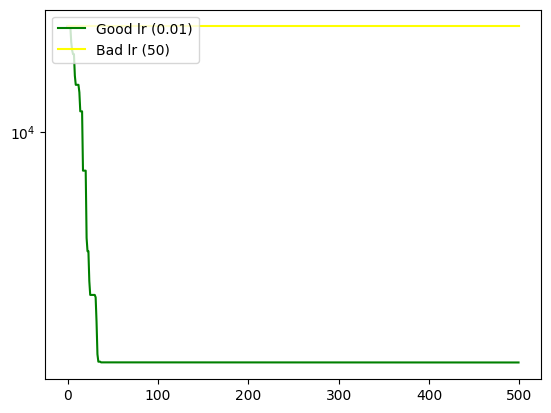

In [1393]:
ln = 500
x_plt = np.arange(ln)
plt.plot(x_plt, LinearRegression.l2_loss(ww_rls, bb_rls, X, y)[x_plt], c='green', label="Good lr (0.01)")
plt.plot(x_plt, LinearRegression.l2_loss(ww_rls_bad, bb_rls_bad, X, y)[x_plt], c='yellow', label="Bad lr (50)")
plt.yscale("symlog")
plt.legend(loc = "upper left")


### Vanilla Gradient Descent
Learning Rate

#### Class

In [1394]:
class GradientDecent(Optimizer):
    def __init__(self, grad, optimizer=None) -> None:
        self.grad = grad
        super().__init__(optimizer)
        pass

    def __call__(self, w, b, X, y, lr) -> tuple[int, int]:
        dw, db = self.grad(w, b, X, y)
        w -= lr * dw
        b -= lr * db
        return w, b

#### Good learning rate

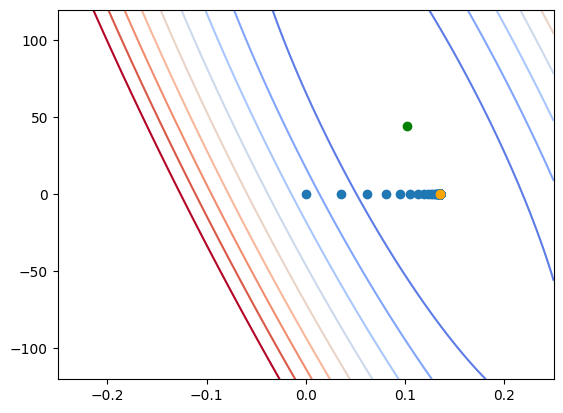

In [1395]:
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad, optimizer=GradientDecent(LinearRegression.l2_grad))
ww_vanilla, bb_vanilla = model.train(X, y, 0.0000001, 500, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_vanilla, bb_vanilla)
plt.scatter(ww_vanilla[-1], bb_vanilla[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")


#### Bad learning rate

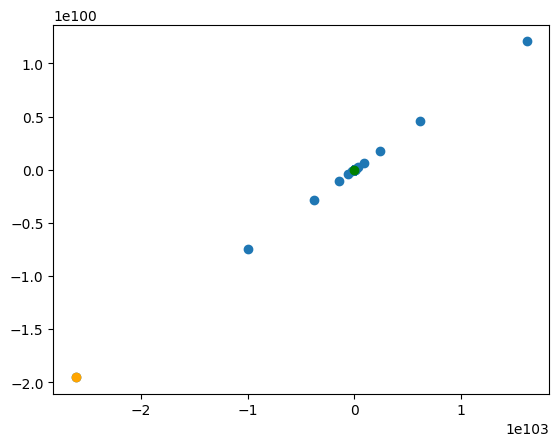

In [1396]:
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad, optimizer=GradientDecent(LinearRegression.l2_grad))
ww_vanilla_bad, bb_vanilla_bad = model.train(X, y, 0.000001, 500, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_vanilla_bad, bb_vanilla_bad)
plt.scatter(ww_vanilla_bad[-1], bb_vanilla_bad[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")


#### Loss comparison

bad learning rate diverges, the good one is unnoticable in comparison

y is on a log scale to show how the bad lr diverges

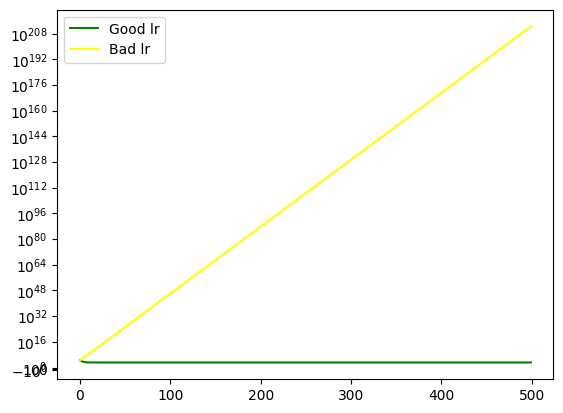

In [1397]:
ln = 500
x_plt = np.arange(ln)
plt.plot(x_plt, LinearRegression.l2_loss(ww_vanilla, bb_vanilla, X, y)[x_plt], c='green', label="Good lr")
plt.plot(x_plt, LinearRegression.l2_loss(ww_vanilla_bad, bb_vanilla_bad, X, y)[x_plt], c='yellow', label="Bad lr")
plt.yscale("symlog")
plt.legend(loc = "upper left")


### Stochastic Gradient Descent
Compute the gradient on a mini batch, with a new parameter batch size. Show the effect of varying batch size

#### Class

In [1398]:
class SGDOptim(GradientDecent):
    def __init__(self, grad, dataset_size, batch_size, optimizer=None) -> None:
        super().__init__(grad, optimizer)
        self.batch_size = batch_size
        self.range = np.arange(dataset_size)


    def __call__(self, w, b, X, y, lr) -> tuple[int, int]:
        to_use = np.random.choice(self.range, (self.batch_size,))
        if self.optim == None:
            return super().__call__(w, b, X[to_use], y[to_use], lr)
        return self.optim(w, b, X[to_use], y[to_use], lr)

#### large batch size

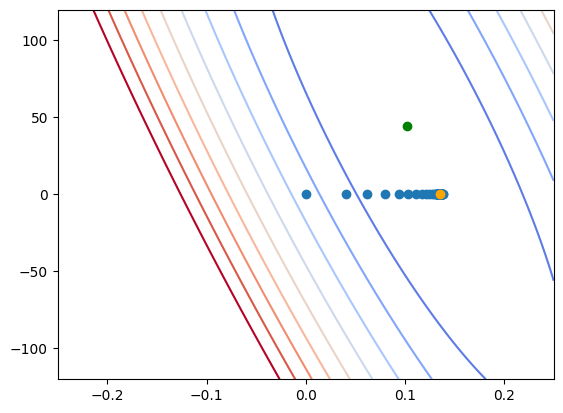

In [1399]:
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad, optimizer=SGDOptim(LinearRegression.l2_grad, len(X), 100))
ww_sgd, bb_sgd = model.train(X, y, 0.0000001, 500, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_sgd, bb_sgd)
plt.scatter(ww_sgd[-1], bb_sgd[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")


#### small batch size

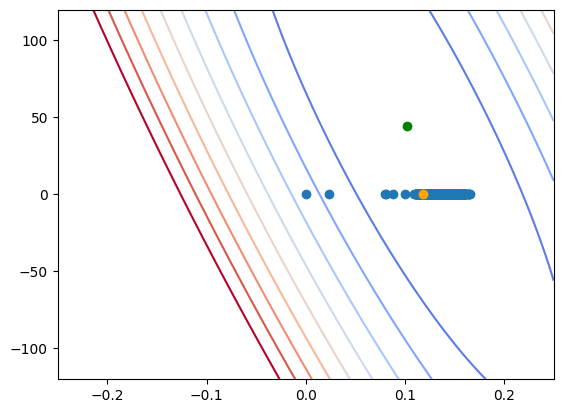

In [1400]:
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad, optimizer=SGDOptim(LinearRegression.l2_grad, len(X), 1))
ww_sgd_bad, bb_sgd_bad = model.train(X, y, 0.0000001, 500, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_sgd_bad, bb_sgd_bad)
plt.scatter(ww_sgd_bad[-1], bb_sgd_bad[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")

#### Loss Comparison

small batch size keeps jumping around, decent batch size is stable

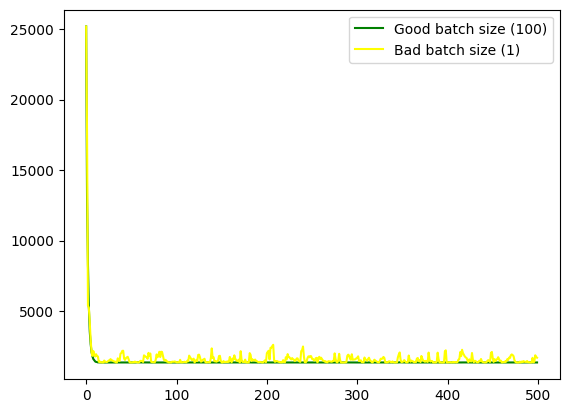

In [1401]:
ln = 500
x_plt = np.arange(ln)
plt.plot(x_plt, LinearRegression.l2_loss(ww_sgd, bb_sgd, X, y)[x_plt], c='green', label="Good batch size (100)")
plt.plot(x_plt, LinearRegression.l2_loss(ww_sgd_bad, bb_sgd_bad, X, y)[x_plt], c='yellow', label="Bad batch size (1)")
plt.legend(loc = "upper right")


### Data rescaling
Normalize data (range [0,1] or range [-1, 1]?)

Standardize data

(make sure you are showing loss relative to the original dataset, also start at the scaled version of $w=0, b=0$ so the loss before taking any steps starts out the same)

#### Functions

In [1402]:
# small helpers
def apply_subtract_and_div(data, minus, div):
    return (data-minus)/div

def do_b(w, b, minus, div, mul, add):
    return (b-add)/mul + minus*w/div

def undo_b(w, b, minus, div, mul, add):
    return (b-minus*w/div)*mul + add

def do_w(w, mul, div):
    return w*div/mul

def undo_w(w, mul, div):
    return w*mul/div

# big guys
def normalize(X, y):
    '''Given X and y, normalize them'''
    X_normed = apply_subtract_and_div(X, np.min(X), np.max(X)-np.min(X))
    y_normed = apply_subtract_and_div(y, np.min(y), np.max(y)-np.min(y))
    return X_normed, y_normed

def denormalize_wb(X, y, w, b):
    '''Given X, y and some normalized w and b, return the original w and b corrosponding to that pair'''
    orig_w = undo_w(w, np.max(y)-np.min(y), np.max(X)-np.min(X))
    orig_b = undo_b(w, b, np.min(X), np.max(X)-np.min(X), np.max(y)-np.min(y), np.min(y))
    return orig_w, orig_b

def normalize_wb(X, y, w, b):
    '''Given X, y and some w and b, return the normalized w and b'''
    new_w = do_w(w, np.max(y)-np.min(y), np.max(X)-np.min(X))
    new_b = do_b(w, b, np.min(X), np.max(X)-np.min(X), np.max(y)-np.min(y), np.min(y))
    return new_w, new_b

def standardize(X, y):
    '''Given X and y, standardize them'''
    X_std = apply_subtract_and_div(X, np.mean(X), np.std(X))
    y_std = apply_subtract_and_div(y, np.mean(y), np.std(y))
    return X_std, y_std

def destandardize_wb(X, y, w, b):
    '''Given X, y and some standardized w and b, return the original w and b corrosponding to that pair'''
    w_orig = undo_w(w, np.std(y), np.std(X))
    b_orig = undo_b(w, b, np.mean(X), np.std(X), np.std(y), np.mean(y))
    return w_orig, b_orig

def standardize_wb(X, y, w, b):
    '''Given X, y and some w and b, return the standardized w and b'''
    w_new = do_w(w, np.std(y), np.std(X))
    b_new = do_b(w, b, np.mean(X), np.std(X), np.std(y), np.mean(y))
    return w_new, b_new

#### Normalization (0 to 1)

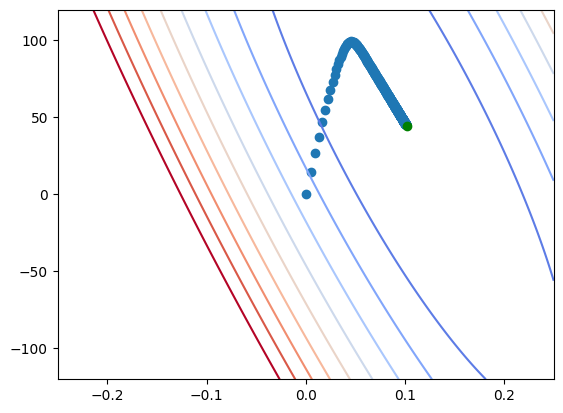

In [1403]:
X_norm, y_norm = normalize(X, y)
model = LinearRegression(*normalize_wb(X, y, 0, 0), LinearRegression.l2_loss, LinearRegression.l2_grad)
ww_norm, bb_norm = denormalize_wb(X, y, *model.train(X_norm, y_norm, 0.05, 500, ret_pts=1))
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_norm, bb_norm)
plt.scatter(ans_w, ans_b, c="green")

#### Standardization

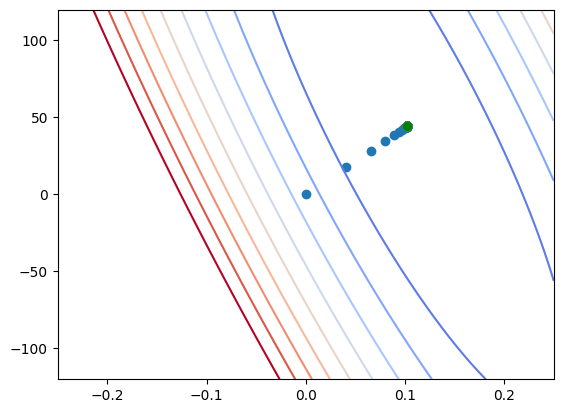

In [1404]:
X_std, y_std = standardize(X, y)
model = LinearRegression(*standardize_wb(X, y, 0, 0), LinearRegression.l2_loss, LinearRegression.l2_grad)
www, bbb = model.train(X_std, y_std, 0.2, 500, ret_pts=1)
ww_std, bb_std = destandardize_wb(X, y, www, bbb)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_std, bb_std)
plt.scatter(ww_std[-1], bb_std[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")

#### Loss Comparison

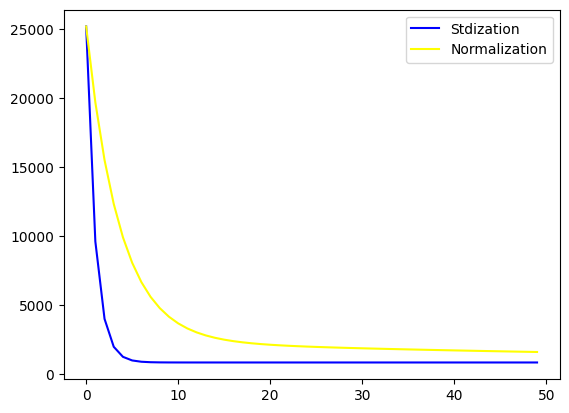

In [1405]:
ln = 50
x_plt = np.arange(ln)
plt.plot(x_plt, LinearRegression.l2_loss(ww_std, bb_std, X, y)[x_plt], c='blue', label="Stdization")
plt.plot(x_plt, LinearRegression.l2_loss(ww_norm, bb_norm, X, y)[x_plt], c='yellow', label="Normalization")
plt.legend(loc = "upper right")


### Momentum
Standard momentum

Nesterov momentum

#### Standard

In [1406]:
class Momentum(Optimizer):
    def __init__(self, grad, mul) -> None:
        super().__init__()
        self.grad = grad
        self.mul = mul
        self.mom_w = 0
        self.mom_b = 0
    
    def __call__(self, w, b, X, y, lr) -> tuple[int, int]:
        dw, db = self.grad(w, b, X, y)
        self.mom_w *= self.mul
        self.mom_b *= self.mul
        self.mom_w += dw
        self.mom_b += db
        w -= lr*self.mom_w
        b -= lr*self.mom_b
        return w, b


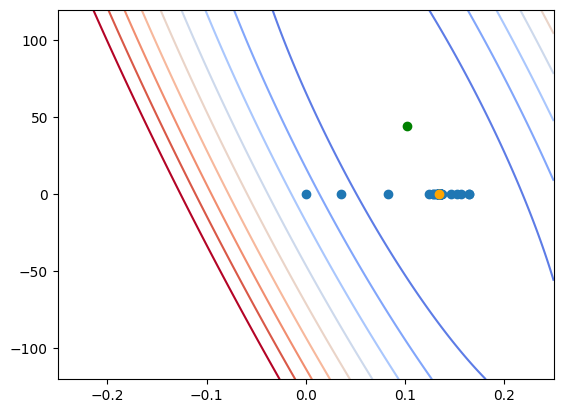

In [1407]:
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad, optimizer=Momentum(LinearRegression.l2_grad, 0.6))
ww_mom, bb_mom = model.train(X, y, 0.0000001, 100000, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_mom, bb_mom)
plt.scatter(ww_mom[-1], bb_mom[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")

#### Nestorov

In [1408]:
class NestorovMomentum(Optimizer):
    def __init__(self, grad, mul) -> None:
        super().__init__()
        self.grad = grad
        self.mul = mul
        self.mom_w = 0
        self.mom_b = 0
    
    def __call__(self, w, b, X, y, lr) -> tuple[int, int]:
        dw, db = self.grad(w-lr*self.mom_w, b-lr*self.mom_b, X, y)
        self.mom_w *= self.mul
        self.mom_b *= self.mul
        self.mom_w += dw
        self.mom_b += db
        w -= lr*self.mom_w
        b -= lr*self.mom_b
        return w, b

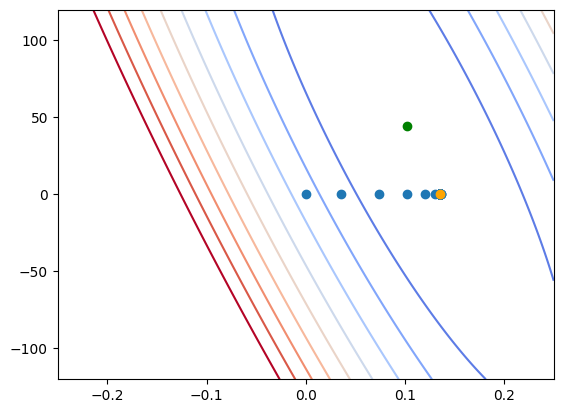

In [1409]:
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad, optimizer=NestorovMomentum(LinearRegression.l2_grad, 0.6))
ww_nest, bb_nest = model.train(X, y, 0.0000001, 500, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_nest, bb_nest)
plt.scatter(ww_nest[-1], bb_nest[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")

#### Loss Comparison

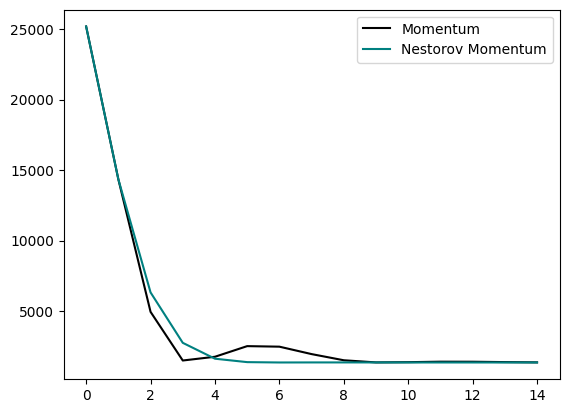

In [1410]:
ln = 15
x_plt = np.arange(ln)
plt.plot(x_plt, LinearRegression.l2_loss(ww_mom, bb_mom, X, y)[x_plt], c='black', label="Momentum")
plt.plot(x_plt, LinearRegression.l2_loss(ww_nest, bb_nest, X, y)[x_plt], c='teal', label="Nestorov Momentum")
plt.legend(loc = "upper right")


### Adaptive Learning Rate (per dimension)

#### Class

In [1411]:
class AdaptiveLrs(Optimizer):
    '''
    Adagrad
    '''
    def __init__(self, grad, optimizer=None) -> None:
        super().__init__(optimizer)
        self.grad = grad
        self.w_sq = 0
        self.b_sq = 0
    
    def __call__(self, w, b, X, y, lr) -> tuple[int, int]:
        dw, db = self.grad(w, b, X, y)
        self.w_sq += dw*dw
        w -= lr*dw / (np.sqrt(self.w_sq) + 1e-9)
        self.b_sq += db*db
        b -= lr*db / (np.sqrt(self.b_sq) + 1e-9)
        return w, b

#### Full Dataset Only

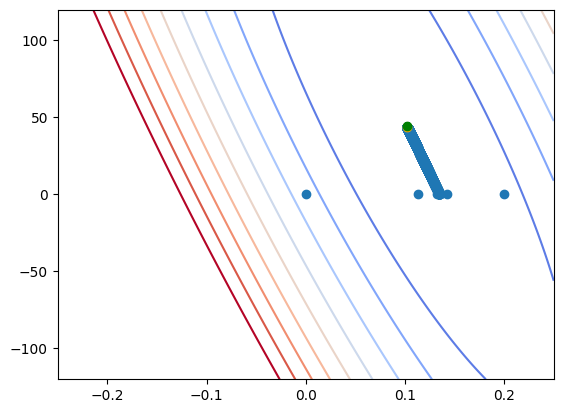

In [1412]:
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad, optimizer=AdaptiveLrs(LinearRegression.l2_grad))
ww_adagrad, bb_adagrad = model.train(X, y, 0.2, 100000, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_adagrad, bb_adagrad)
plt.scatter(ww_adagrad[-1], bb_adagrad[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")

#### Loss

short x range as it gets boring afterwards

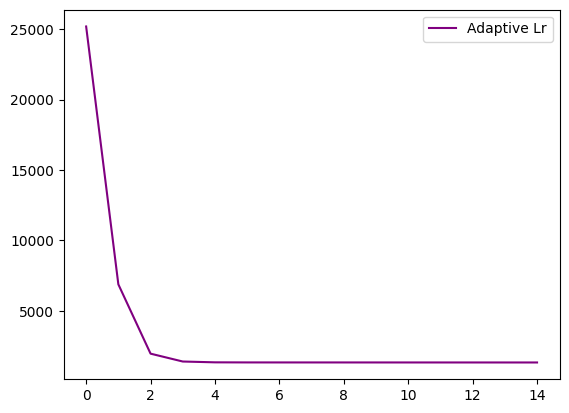

In [1413]:
ln = 15
x_plt = np.arange(ln)
plt.plot(x_plt, LinearRegression.l2_loss(ww_adagrad, bb_adagrad, X, y)[x_plt], c='purple', label="Adaptive Lr")
plt.legend(loc = "upper right")

### Rprop

This should not work well on minibatches. Confirm this by also using batches of various sizes

#### Class

In [1414]:
class RProp(Optimizer):
    def __init__(self, grad, incr = 1.2, decr = 0.5, initial_lr = 1, optimizer=None) -> None:
        super().__init__(optimizer)
        self.grad = grad
        self.incr = incr
        self.decr = decr
        self.old_dw = 0
        self.old_db = 0
        self.lr_w = initial_lr
        self.lr_b = initial_lr
    
    def __call__(self, w, b, X, y, lr) -> tuple[int, int]:
        dw, db = self.grad(w, b, X, y)
        if (np.sign(self.old_dw) == np.sign(dw)):
            self.lr_w *= self.incr
        else:
            self.lr_w *= self.decr
        
        if (np.sign(self.old_db) == np.sign(db)):
            self.lr_b *= self.incr
        else:
            self.lr_b *= self.decr

        b -= db*(self.lr_b)
        w -= dw*(self.lr_w)
        self.old_dw = dw
        self.old_db = db
        return w, b

#### Full Dataset

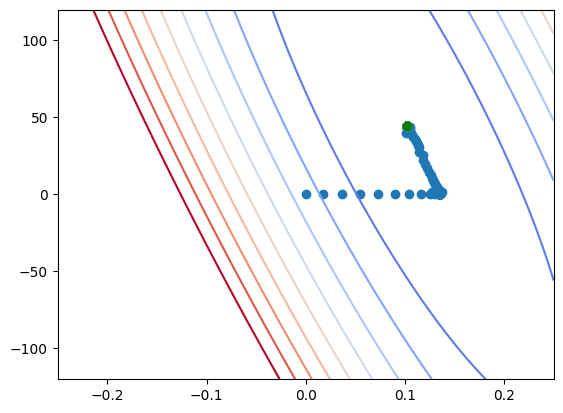

In [1415]:
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad, optimizer=RProp(LinearRegression.l2_grad, initial_lr=0.0000001))
ww_rprop, bb_rprop = model.train(X, y, 0.01, 500, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_rprop, bb_rprop)
# if orange can't be seen, that means its directly under green which is huge success
plt.scatter(ww_rprop[-1], bb_rprop[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")

#### Small batch size

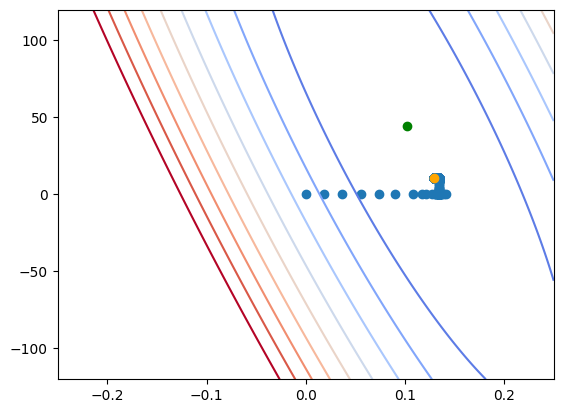

In [1416]:
# batch size = 50 
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad, optimizer=SGDOptim(LinearRegression.l2_grad, len(X), 50, optimizer=RProp(LinearRegression.l2_grad, initial_lr=0.0000001)))
ww_rprop_sgd, bb_rprop_sgd = model.train(X, y, 0.01, 500, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_rprop_sgd, bb_rprop_sgd)
plt.scatter(ww_rprop_sgd[-1], bb_rprop_sgd[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")

#### Loss Comparison
The graphs for small batch vs full dataset are the same while w is changing, but b changes much better with the full dataset leading to that eventual dip in the loss that indicates it is better

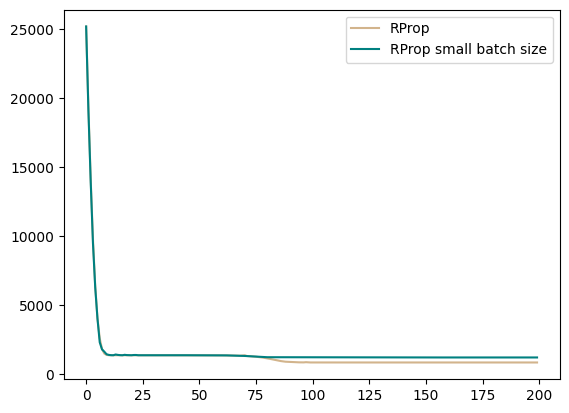

In [1417]:
ln = 200
x_plt = np.arange(ln)
plt.plot(x_plt, LinearRegression.l2_loss(ww_rprop, bb_rprop, X, y)[x_plt], c='tan', label="RProp")
plt.plot(x_plt, LinearRegression.l2_loss(ww_rprop_sgd, bb_rprop_sgd, X, y)[x_plt], c='teal', label="RProp small batch size")
plt.legend(loc = "upper right")

### RMS Prop

This should work better on minibatches. Confirm this by also using batches of various sizes

#### Class

In [1418]:
class RMSProp(Optimizer):
    def __init__(self, grad, decay, optimizer=None) -> None:
        super().__init__(optimizer)
        self.grad = grad
        self.w_gradsq = 0
        self.b_gradsq = 0
        self.decay = decay

    def __call__(self, w, b, X, y, lr) -> tuple[int, int]:
        dw, db = self.grad(w, b, X, y)
        self.w_gradsq= self.decay * self.w_gradsq + (1-self.decay) * dw*dw
        w -= lr*dw / (np.sqrt(self.w_gradsq) + 1e-9)
        self.b_gradsq = self.decay * self.b_gradsq + (1-self.decay) * db*db
        b -= lr*db / (np.sqrt(self.b_gradsq) + 1e-9)
        return w, b


#### Full Dataset

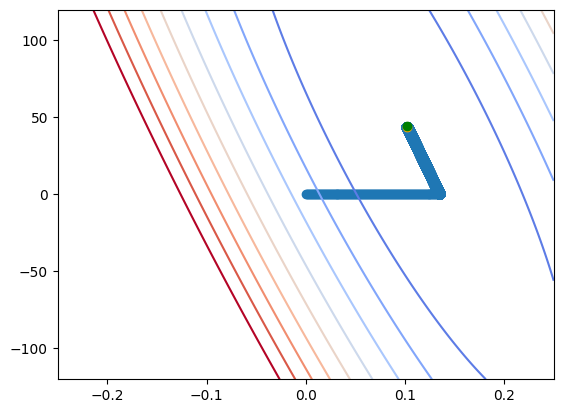

In [1419]:
# converges with enough time
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad, optimizer=RMSProp(LinearRegression.l2_grad, 0.1))
ww_rmsprop, bb_rmsprop = model.train(X, y, 0.001, 100000, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_rmsprop, bb_rmsprop)
plt.scatter(ww_rmsprop[-1], bb_rmsprop[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")

#### Small Batch Size

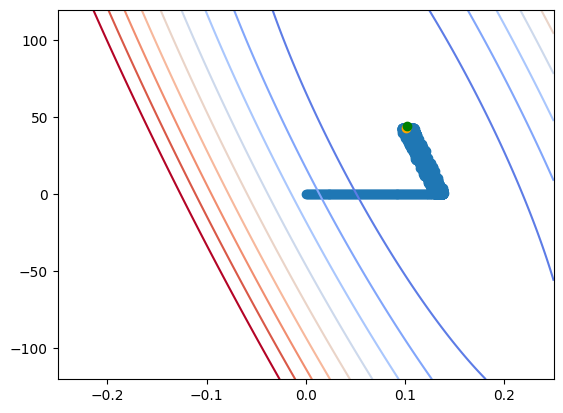

In [1420]:
# batch size = 30
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad, optimizer=SGDOptim(LinearRegression.l2_grad, len(X), 30, optimizer=RMSProp(LinearRegression.l2_grad, 0.1)))
ww_rmsprop_sgd, bb_rmsprop_sgd = model.train(X, y, 0.001, 100000, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_rmsprop_sgd, bb_rmsprop_sgd)
plt.scatter(ww_rmsprop_sgd[-1], bb_rmsprop_sgd[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")

#### Loss Comparison

overall about the same

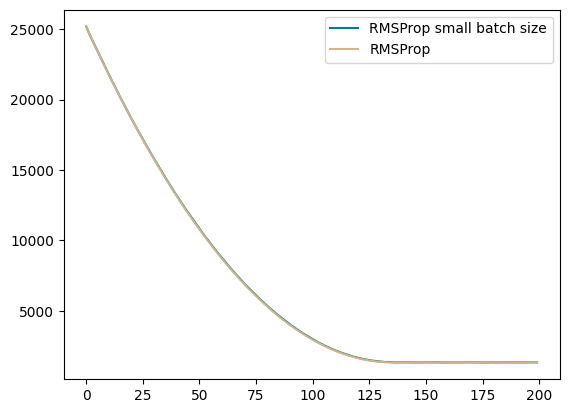

In [1421]:
ln = 200
x_plt = np.arange(ln)
plt.plot(x_plt, LinearRegression.l2_loss(ww_rmsprop_sgd, bb_rmsprop_sgd, X, y)[x_plt], c='teal', label="RMSProp small batch size")
plt.plot(x_plt, LinearRegression.l2_loss(ww_rmsprop, bb_rmsprop, X, y)[x_plt], c='tan', label="RMSProp")
plt.legend(loc = "upper right")


### Adam

#### Class

In [1422]:
class Adam(Optimizer):
    def __init__(self, grad, beta1, beta2, optimizer=None) -> None:
        super().__init__(optimizer)
        self.grad = grad
        self.w_first_mom = 0
        self.w_second_mom = 0
        self.b_first_mom = 0
        self.b_second_mom = 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = 0

    def __call__(self, w, b, X, y, lr) -> tuple[int, int]:
        self.t += 1
        dw, db = self.grad(w, b, X, y)
        self.w_first_mom = self.beta1*self.w_first_mom + (1-self.beta1) * dw
        self.w_second_mom = self.beta2*self.w_second_mom + (1-self.beta2) * dw * dw
        w_first_unbias = self.w_first_mom / (1-self.beta1**self.t)
        w_second_unbias = self.w_second_mom / (1-self.beta2**self.t)
        w -= lr*w_first_unbias / (np.sqrt(w_second_unbias) + 1e-7)

        self.b_first_mom = self.beta1*self.b_first_mom + (1-self.beta1) * db
        self.b_second_mom = self.beta2*self.b_second_mom + (1-self.beta2) * db * db
        b_first_unbias = self.b_first_mom / (1-self.beta1**self.t)
        b_second_unbias = self.b_second_mom / (1-self.beta2**self.t)
        b -= lr*b_first_unbias / (np.sqrt(b_second_unbias) + 1e-7)

        return w, b


#### Full Dataset Only

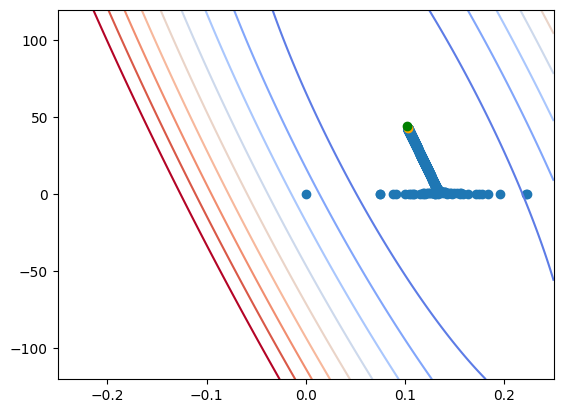

In [1423]:
# converges with time
model = LinearRegression(0, 0, LinearRegression.l2_loss, LinearRegression.l2_grad, optimizer=Adam(LinearRegression.l2_grad, 0.9, 0.999))
ww_adam, bb_adam = model.train(X, y, 0.1, 1500, ret_pts=1)
plotContour(w_contour, b_contour, X, y, LinearRegression.l2_loss, levels=lvls[2])
plt.scatter(ww_adam, bb_adam)
plt.scatter(ww_adam[-1], bb_adam[-1], c="orange")
plt.scatter(ans_w, ans_b, c="green")

#### Loss

symmetric log scale

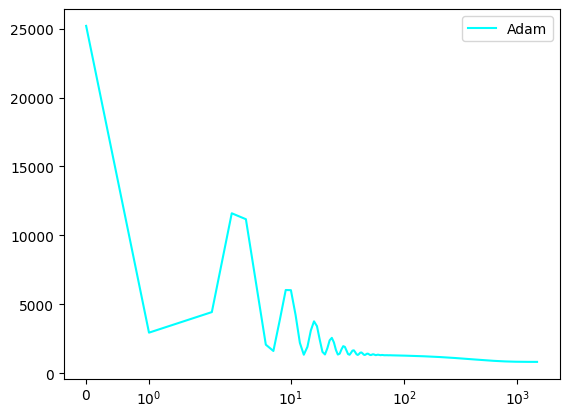

In [1424]:
ln = 1500
x_plt = np.arange(ln)
plt.plot(x_plt, LinearRegression.l2_loss(ww_adam, bb_adam, X, y)[x_plt], c='cyan', label="Adam")
plt.legend(loc = "upper right")
plt.xscale("symlog")

## Final comparison

Get one plot comparing different optimization schemes, both in showing their trajectories and also showing their loss plots (for each scheme, you can choose the best hyperparamters you found in the above search)

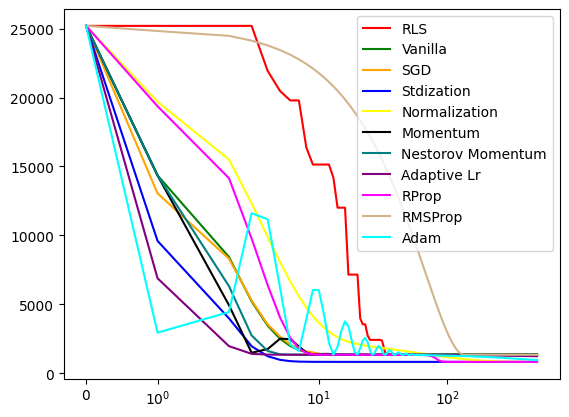

In [1425]:
# only show first ln results, at most 500
# all learning rates are either 0.01 or 0.0000001 (for vanilla, sgd, and momentums, where nonscaled, original data where 0.01 is too big.)
ln = 500
x_plt = np.arange(ln)
plt.plot(x_plt, LinearRegression.l2_loss(ww_rls, bb_rls, X, y)[x_plt], c='red', label="RLS")
plt.plot(x_plt, LinearRegression.l2_loss(ww_vanilla, bb_vanilla, X, y)[x_plt], c='green', label="Vanilla")
plt.plot(x_plt, LinearRegression.l2_loss(ww_sgd, bb_sgd, X, y)[x_plt], c='orange', label="SGD")
plt.plot(x_plt, LinearRegression.l2_loss(ww_std, bb_std, X, y)[x_plt], c='blue', label="Stdization")
plt.plot(x_plt, LinearRegression.l2_loss(ww_norm, bb_norm, X, y)[x_plt], c='yellow', label="Normalization")
plt.plot(x_plt, LinearRegression.l2_loss(ww_mom, bb_mom, X, y)[x_plt], c='black', label="Momentum")
plt.plot(x_plt, LinearRegression.l2_loss(ww_nest, bb_nest, X, y)[x_plt], c='teal', label="Nestorov Momentum")
plt.plot(x_plt, LinearRegression.l2_loss(ww_adagrad, bb_adagrad, X, y)[x_plt], c='purple', label="Adaptive Lr")
plt.plot(x_plt, LinearRegression.l2_loss(ww_rprop, bb_rprop, X, y)[x_plt], c='magenta', label="RProp")
plt.plot(x_plt, LinearRegression.l2_loss(ww_rmsprop, bb_rmsprop, X, y)[x_plt], c='tan', label="RMSProp")
plt.plot(x_plt, LinearRegression.l2_loss(ww_adam, bb_adam, X, y)[x_plt], c='cyan', label="Adam")

plt.legend(loc = "upper right")
# log plot is nice
plt.xscale("symlog")
# plt.yscale("log")


# Sources & Credits

https://stackoverflow.com/questions/19125722/adding-a-matplotlib-legend

plus respective language documentation

Credit to Jasper for some numpy assistance early on and giving me a first step on how to compute the closed form for L2

Credit to Thomas for help in some math stuff early on in the assignment